In [ ]:
#whole lotta inputs ASTRO RELated
from astroquery.vizier import Vizier
import astropy.units as u

import matplotlib.pyplot as plt
import astropy.units as u
import csv
#from astropy.io import fits
from astropy.table import Table
#from astropy.wcs import WCS
#import astroquery
#from astropy.coordinates import SkyCoord
#from astroquery.mast import Observations
#from astroquery.mast import Catalogs
#from astroquery.mast import Tesscut



import numpy as np

#machine learning inputs
import sklearn as sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [168]:
galah = Table.read('/Users/alexabeyer/Desktop/research/data/GALAH_DR3_main_allstar_v2.fits')
galah.colnames


['APOGEE_ID',
 'sobject_id',
 'dr2_source_id',
 'dr3_source_id',
 'survey_name',
 'field_id',
 'flag_repeat',
 'wg4_field',
 'wg4_pipeline',
 'flag_sp',
 'teff',
 'e_teff',
 'irfm_teff',
 'irfm_ebv',
 'irfm_ebv_ref',
 'logg',
 'e_logg',
 'fe_h',
 'e_fe_h',
 'flag_fe_h',
 'fe_h_atmo',
 'vmic',
 'vbroad',
 'e_vbroad',
 'chi2_sp',
 'alpha_fe',
 'e_alpha_fe',
 'nr_alpha_fe',
 'flag_alpha_fe',
 'flux_A_Fe',
 'chi_A_Fe',
 'Li_fe',
 'e_Li_fe',
 'nr_Li_fe',
 'flag_Li_fe',
 'C_fe',
 'e_C_fe',
 'nr_C_fe',
 'flag_C_fe',
 'O_fe',
 'e_O_fe',
 'nr_O_fe',
 'flag_O_fe',
 'Na_fe',
 'e_Na_fe',
 'nr_Na_fe',
 'flag_Na_fe',
 'Mg_fe',
 'e_Mg_fe',
 'nr_Mg_fe',
 'flag_Mg_fe',
 'Al_fe',
 'e_Al_fe',
 'nr_Al_fe',
 'flag_Al_fe',
 'Si_fe',
 'e_Si_fe',
 'nr_Si_fe',
 'flag_Si_fe',
 'K_fe',
 'e_K_fe',
 'nr_K_fe',
 'flag_K_fe',
 'Ca_fe',
 'e_Ca_fe',
 'nr_Ca_fe',
 'flag_Ca_fe',
 'Sc_fe',
 'e_Sc_fe',
 'nr_Sc_fe',
 'flag_Sc_fe',
 'Sc2_fe',
 'e_Sc2_fe',
 'nr_Sc2_fe',
 'flag_Sc2_fe',
 'Ti_fe',
 'e_Ti_fe',
 'nr_Ti_fe',
 'fl

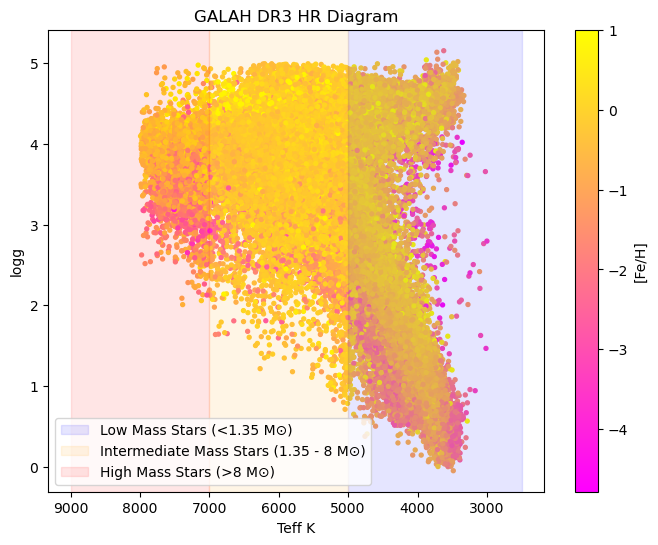

In [ ]:
plt.figure(figsize=(8, 6))


sc = plt.scatter(galah['teff'], galah['logg'], c=galah['fe_h'], cmap='spring', s=8)
plt.colorbar(sc, label='[Fe/H]')
plt.gca().invert_xaxis()
plt.xlabel('Teff K')
plt.ylabel("logg")
# plt.ylim(-100,50e4)
plt.title("GALAH DR3 HR Diagram")

#Hr diagram markers 
teff = galah['teff']
# Define mass boundaries (for example, in solar masses)
low_mass = (teff < 6550)  # Low mass stars have lower Teff (this is a rough example)
intermediate_mass = (teff >= 6550) & (teff < 7000)  # Intermediate mass
high_mass = (teff >= 7000)  # High mass stars

# Plot shaded regions for mass groups
plt.axvspan(2500, 5000, color='blue', alpha=0.1, label='Low Mass Stars (<1.35 M⊙)')
plt.axvspan(5000, 7000, color='orange', alpha=0.1, label='Intermediate Mass Stars (1.35 - 8 M⊙)')
plt.axvspan(7000, 9000, color='red', alpha=0.1, label='High Mass Stars (>8 M⊙)')

# # Annotating the regions (optional)
# plt.annotate('Low Mass Stars', xy=(4500, 5), xytext=(4500, 4.7),
#              arrowprops=dict(facecolor='blue', shrink=0.05), color='blue', fontsize=10)
# plt.annotate('Intermediate Mass Stars', xy=(6000, 4), xytext=(6000, 4.2),
#              arrowprops=dict(facecolor='orange', shrink=0.05), color='orange', fontsize=10)
# plt.annotate('High Mass Stars', xy=(18000, -2), xytext=(18000, -2.2),
#              arrowprops=dict(facecolor='red', shrink=0.05), color='red', fontsize=10)

# Show the plot
plt.legend()
plt.savefig('galah_hrdiagram.png')
plt.show()

In [257]:
gaia = Table.read('/Users/alexabeyer/Desktop/machinelearning/gaia_xgboost.fits')

In [275]:
#defining variables 
apparent_mag = gaia['phot_g_mean_mag']
parallax = gaia['parallax']
teff = gaia['teff_xgboost']
abs_mag = apparent_mag * 5 * np.log10(1/parallax)
gaia['abs_mag'] = abs_mag
gaia['bp_rp'] = gaia['phot_bp_mean_mag'] - gaia['phot_rp_mean_mag']

print(len(gaia))

17558141


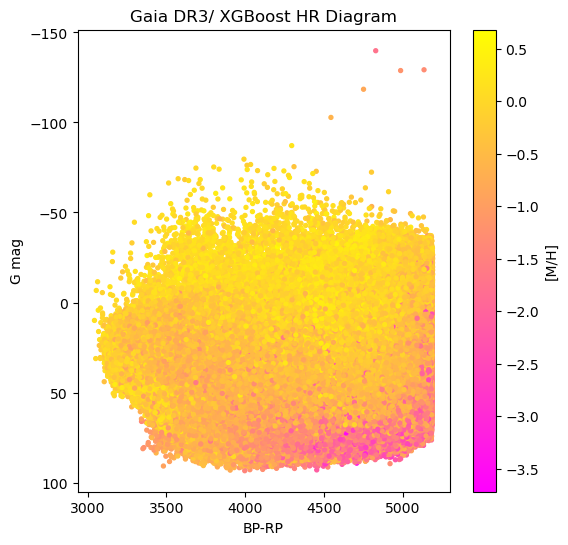

In [277]:
plt.figure(figsize=(6, 6))
bp_rp = gaia['teff_xgboost'] - gaia['phot_rp_mean_mag']

sc = plt.scatter(bp_rp, gaia['abs_mag'], c=gaia['mh_xgboost'], cmap='spring', s=8)
plt.colorbar(sc, label='[M/H]')
# plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('BP-RP' )
plt.ylabel("G mag")
# plt.ylim(-100,50e4)
plt.title("Gaia DR3/ XGBoost HR Diagram")

# #Hr diagram markers 
# teff = gaia['teff_xgboost']
# # Define mass boundaries (for example, in solar masses)
# low_mass = (teff < 6450)  # Low mass stars have lower Teff (this is a rough example)
# intermediate_mass = (teff >= 6550) & (teff < 7000)  # Intermediate mass
# high_mass = (teff >= 7000)  # High mass stars

# # Plot shaded regions for mass groups
# plt.axvspan(2500, 6550, color='blue', alpha=0.1, label='Low Mass Stars (<1.35 M⊙)')
# plt.axvspan(6550, 7000, color='orange', alpha=0.1, label='Intermediate Mass Stars (1.35 - 8 M⊙)')
# plt.axvspan(7000, 9000, color='red', alpha=0.1, label='High Mass Stars (>8 M⊙)')

# # Annotating the regions (optional)
# plt.annotate('Low Mass Stars', xy=(4500, 5), xytext=(4500, 4.7),
#              arrowprops=dict(facecolor='blue', shrink=0.05), color='blue', fontsize=10)
# plt.annotate('Intermediate Mass Stars', xy=(6000, 4), xytext=(6000, 4.2),
#              arrowprops=dict(facecolor='orange', shrink=0.05), color='orange', fontsize=10)
# plt.annotate('High Mass Stars', xy=(18000, -2), xytext=(18000, -2.2),
#              arrowprops=dict(facecolor='red', shrink=0.05), color='red', fontsize=10)

# Show the plot

plt.savefig('gaia_hrdiagram.png')
plt.show()


In [176]:
GALAH = galah["teff", #Effective temperature of the star (a derived quantity)
    #"e_Teff", #Error in effective temperature
    "logg", #Log surface gravity
    #"e_logg", #error in surface gravity
    "fe_h", #Metallicity (ratio of iron to hydrogen)
    #"e_FeH", #error in metallicit
    "vbroad" #rotational velocity 
]

df = GALAH.to_pandas()
df = df.dropna()
df

,teff,logg,fe_h,vbroad
0,4553.354492,4.714953,-0.335019,9.345594
2,4852.475586,2.466885,-1.170157,8.185776
3,5588.500488,3.999357,0.052395,12.291694
4,5709.502930,4.181905,-0.013732,12.961143
5,6235.314453,4.100623,-0.323570,9.967797
...,...,...,...,...
588566,4531.215332,2.410332,-0.293808,6.775260
588567,6059.499512,3.519315,-0.045074,15.524404
588568,4132.972656,0.959392,-1.003942,7.007711
588569,4776.927246,2.420797,0.007314,7.417721


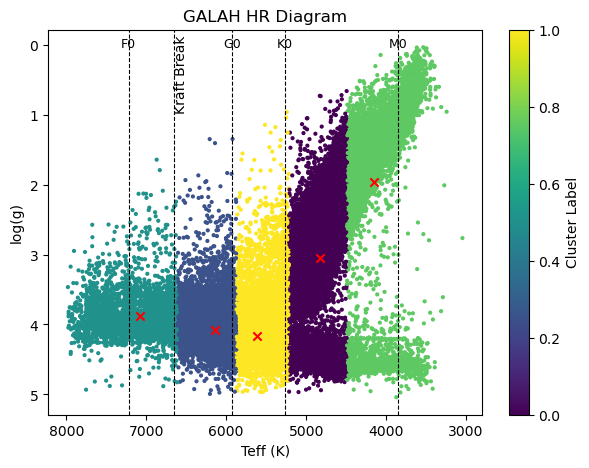

In [286]:

fitcols = [
    "teff", #Effective temperature of the star (a derived quantity)
    #"e_Teff", #Error in effective temperature
    "logg", #Log surface gravity
    #"e_logg", #error in surface gravity
    "fe_h", #Metallicity (ratio of iron to hydrogen)
    #"e_FeH", #error in metallicit
    "vbroad" #rotational velocity 
    
]
X = df[fitcols]
y=df['teff']
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

#plot
plt.figure(figsize=(7, 5))
plt.scatter( X['teff'].iloc[::5], X['logg'].iloc[::5], c=labels[::5], s=4, cmap='viridis')
plt.scatter(np.array(centers[:,0]), np.array(centers[:,1]), marker='x', c='r')
plt.title("GALAH HR Diagram")
plt.ylabel('log(g)')
plt.xlabel('Teff (K)')
plt.gca().invert_yaxis()      # Teff increases downward
plt.gca().invert_xaxis()      # Optional, if x-axis is Teff

spectral_types_break = ['F0', 'Kraft Break', 'G0', 'K0', 'M0']
teff_values = [7220, 6650, 5930, 5270, 3850]
spectral_types = ['F0', 'G0', 'K0', 'M0']
logL_values = ['0.86', '0.13', '-0.34', '-1.16']
bp_rp_values = ['0.377', '0.784', '0.983', '1.84'] 

y_top = plt.ylim()[1]

for teff, label in zip(teff_values, spectral_types_break):
    plt.axvline(teff, color='black', linestyle='--', linewidth=0.8)
    
    if label == 'Kraft Break':
        plt.text(teff, y_top + 1.2, label, rotation=90, verticalalignment='bottom',
                 horizontalalignment='left', fontsize=10, color='black')
    else:
        plt.text(teff, y_top + 0.3, label, rotation=0, verticalalignment='bottom',
                 horizontalalignment='center', fontsize=9, color='black')

plt.colorbar(label='Cluster Label')
plt.savefig('galah_hrdiagram_cluster5.png')

plt.show()

In [245]:
GAIA = gaia['teff_xgboost', 'abs_mag', 'logg_xgboost', 'bp_rp', 'phot_rp_mean_mag']

gaia_df = GAIA.to_pandas()
gaia_df = gaia_df.dropna()
gaia_df

,teff_xgboost,abs_mag,logg_xgboost,bp_rp,phot_rp_mean_mag
0,5065.8,-8.116050,2.993,5056.204252,9.595748
1,4499.0,14.314481,1.916,4489.258291,9.741709
2,4643.6,4.017356,2.398,4633.118262,10.481738
3,5153.1,-7.654524,3.363,5141.700490,11.399510
4,4634.5,5.895078,2.573,4623.379578,11.120422
...,...,...,...,...,...
2335953,4760.2,17.599975,2.445,4748.591355,11.608645
2335954,4868.3,16.334495,3.427,4854.526520,13.773480
2335955,4487.9,-8.433293,2.196,4479.551963,8.348037
2335956,4948.4,5.298114,3.480,4935.409556,12.990444


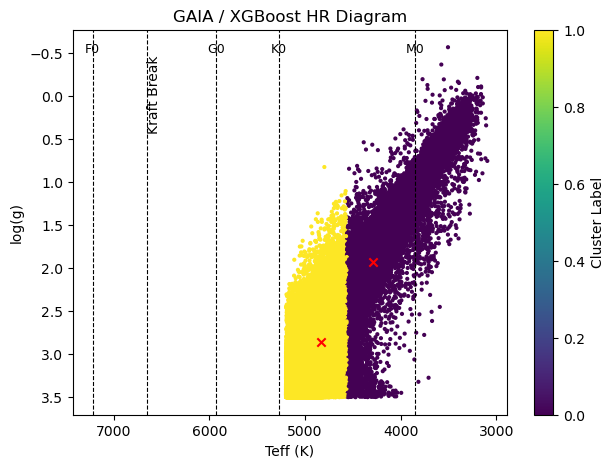

In [292]:
fitcols = [
    "teff_xgboost", #Effective temperature of the star (a derived quantity)
    #"e_Teff", #Error in effective temperature
    "logg_xgboost", #Log surface gravity
    #"e_logg", #error in surface gravity
    "bp_rp", #Metallicity (ratio of iron to hydrogen)
    #"e_FeH", #error in metallicit
    "abs_mag" #rotational velocity 
    
]
X = gaia_df[fitcols]
y=gaia_df['teff_xgboost']
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

#plot
plt.figure(figsize=(7, 5))
plt.scatter( X['teff_xgboost'].iloc[::5], X['logg_xgboost'].iloc[::5], c=labels[::5], s=4, cmap='viridis')
plt.scatter(np.array(centers[:,0]), np.array(centers[:,1]), marker='x', c='r')
plt.title("GAIA / XGBoost HR Diagram")
plt.ylabel('log(g)')
plt.xlabel('Teff (K)')
plt.gca().invert_yaxis()      # Teff increases downward
plt.gca().invert_xaxis()      # Optional, if x-axis is Teff

spectral_types_break = ['F0', 'Kraft Break', 'G0', 'K0', 'M0']
teff_values = [7220, 6650, 5930, 5270, 3850]
spectral_types = ['F0', 'G0', 'K0', 'M0']
logL_values = ['0.86', '0.13', '-0.34', '-1.16']
bp_rp_values = ['0.377' , '0.784', '0.983', '1.84'] 

y_top = plt.ylim()[1]

for teff, label in zip(teff_values, spectral_types_break):
    plt.axvline(teff, color='black', linestyle='--', linewidth=0.8)
    
    if label == 'Kraft Break':
        plt.text(teff, y_top + 1.2, label, rotation=90, verticalalignment='bottom',
                 horizontalalignment='left', fontsize=10, color='black')
    else:
        plt.text(teff, y_top + 0.3, label, rotation=0, verticalalignment='bottom',
                 horizontalalignment='center', fontsize=9, color='black')

plt.colorbar(label='Cluster Label')
plt.savefig('gaia_hrdiagram_cluster.png')
plt.show()

In [307]:
#gaia? 
ugh = Table.read("GKTHCatalog_Table4.csv")
ugh = ugh[ugh['iso_teff'] < 9000]
ugh.colnames

['id_starname',
 'iso_teff',
 'iso_teff_err1',
 'iso_teff_err2',
 'iso_logg',
 'iso_logg_err1',
 'iso_logg_err2',
 'iso_feh',
 'iso_feh_err1',
 'iso_feh_err2',
 'iso_mass',
 'iso_mass_err1',
 'iso_mass_err2',
 'iso_rad',
 'iso_rad_err1',
 'iso_rad_err2',
 'iso_rho',
 'iso_rho_err1',
 'iso_rho_err2',
 'iso_lum',
 'iso_lum_err1',
 'iso_lum_err2',
 'iso_age',
 'iso_age_err1',
 'iso_age_err2',
 'iso_dis',
 'iso_dis_err1',
 'iso_dis_err2',
 'iso_avs']

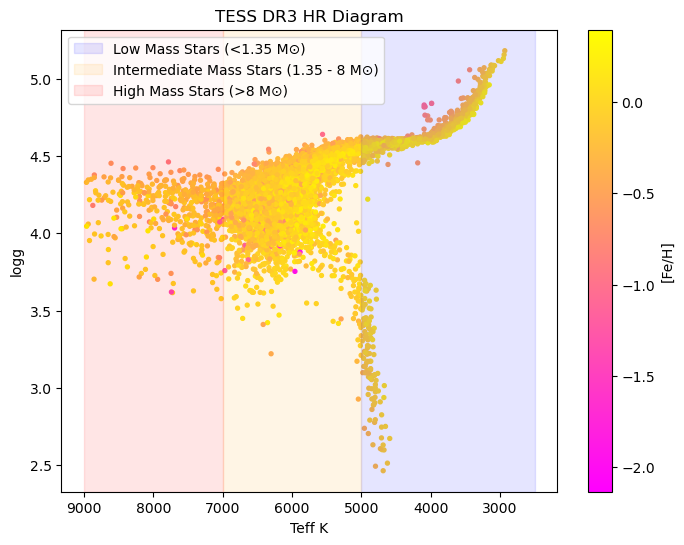

In [305]:
plt.figure(figsize=(8, 6))


sc = plt.scatter(ugh['iso_teff'], ugh['iso_logg'], c=ugh['iso_feh'], cmap='spring', s=8)
plt.colorbar(sc, label='[Fe/H]')
plt.gca().invert_xaxis()
plt.xlabel('Teff K')
plt.ylabel("logg")
# plt.ylim(-100,50e4)
plt.title("TESS DR3 HR Diagram")

#Hr diagram markers 
teff = ugh['iso_teff']
# Define mass boundaries (for example, in solar masses)
low_mass = (teff < 6450)  # Low mass stars have lower Teff (this is a rough example)
intermediate_mass = (teff >= 6550) & (teff < 7000)  # Intermediate mass
high_mass = (teff >= 7000)  # High mass stars

# Plot shaded regions for mass groups
plt.axvspan(2500, 5000, color='blue', alpha=0.1, label='Low Mass Stars (<1.35 M⊙)')
plt.axvspan(5000, 7000, color='orange', alpha=0.1, label='Intermediate Mass Stars (1.35 - 8 M⊙)')
plt.axvspan(7000, 9000, color='red', alpha=0.1, label='High Mass Stars (>8 M⊙)')

# # Annotating the regions (optional)
# plt.annotate('Low Mass Stars', xy=(4500, 5), xytext=(4500, 4.7),
#              arrowprops=dict(facecolor='blue', shrink=0.05), color='blue', fontsize=10)
# plt.annotate('Intermediate Mass Stars', xy=(6000, 4), xytext=(6000, 4.2),
#              arrowprops=dict(facecolor='orange', shrink=0.05), color='orange', fontsize=10)
# plt.annotate('High Mass Stars', xy=(18000, -2), xytext=(18000, -2.2),
#              arrowprops=dict(facecolor='red', shrink=0.05), color='red', fontsize=10)

# Show the plot
plt.legend()
plt.savefig('tess_hrdiagram.png')
plt.show()

In [311]:
TESS = ugh['iso_teff', 'iso_logg', 'iso_feh', 'iso_lum', 'iso_mass']

tess_df = TESS.to_pandas()
tess_df = tess_df.dropna()
tess_df

,iso_teff,iso_logg,iso_feh,iso_lum,iso_mass
0,5610.428845,4.497660,-0.034105,0.729697,0.935053
1,5832.172919,4.352472,0.102351,1.314130,1.054473
2,5660.415369,4.475518,-0.079961,0.793808,0.935793
3,5837.403566,4.423377,0.046694,1.119828,1.033088
4,4845.001030,4.577101,0.013062,0.274921,0.755394
...,...,...,...,...,...
7901,6583.313148,4.239971,-0.032656,3.449363,1.295246
7902,7943.750417,4.251967,-0.031419,9.081913,1.641027
7903,8006.163534,4.211495,-0.137903,10.023585,1.636713
7904,8411.401871,4.138061,0.066914,17.120154,1.897798


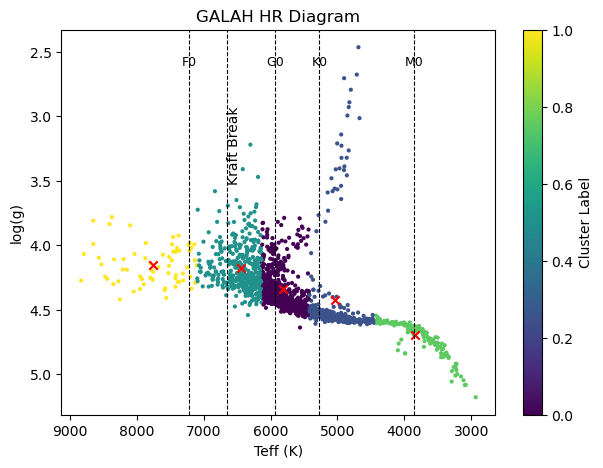

In [319]:

fitcols = [
    "iso_teff", #Effective temperature of the star (a derived quantity)
    #"e_Teff", #Error in effective temperature
    "iso_logg", #Log surface gravity
    #"e_logg", #error in surface gravity
    "iso_feh", #Metallicity (ratio of iron to hydrogen)
    #"e_FeH", #error in metallicit
    "iso_lum", #luminosity
    'iso_mass'
    
]
X = tess_df[fitcols]
y=tess_df['iso_teff']
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

#plot
plt.figure(figsize=(7, 5))
plt.scatter( X['iso_teff'].iloc[::5], X['iso_logg'].iloc[::5], c=labels[::5], s=4, cmap='viridis')
plt.scatter(np.array(centers[:,0]), np.array(centers[:,1]), marker='x', c='r')
plt.title("GALAH HR Diagram")
plt.ylabel('log(g)')
plt.xlabel('Teff (K)')
plt.gca().invert_yaxis()      # Teff increases downward
plt.gca().invert_xaxis()      # Optional, if x-axis is Teff

spectral_types_break = ['F0', 'Kraft Break', 'G0', 'K0', 'M0']
teff_values = [7220, 6650, 5930, 5270, 3850]
spectral_types = ['F0', 'G0', 'K0', 'M0']
logL_values = ['0.86', '0.13', '-0.34', '-1.16']
bp_rp_values = ['0.377', '0.784', '0.983', '1.84'] 

y_top = plt.ylim()[1]

for teff, label in zip(teff_values, spectral_types_break):
    plt.axvline(teff, color='black', linestyle='--', linewidth=0.8)
    
    if label == 'Kraft Break':
        plt.text(teff, y_top + 1.2, label, rotation=90, verticalalignment='bottom',
                 horizontalalignment='left', fontsize=10, color='black')
    else:
        plt.text(teff, y_top + 0.3, label, rotation=0, verticalalignment='bottom',
                 horizontalalignment='center', fontsize=9, color='black')

plt.colorbar(label='Cluster Label')
plt.savefig('TESS_hrdiagram_cluster5.png')

plt.show()